Run the cell below if you are using Google Colab to mount your Google Drive in your Colab instance. Adjust the path to the files in your Google Drive as needed if it differs.

If you do not use Google Colab, running the cell will simply do nothing, so do not worry about it.

In [6]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/Colab Notebooks/06_Regression'
except ImportError as e:
    pass

In [1]:
#%pip install plotly

Let's have a look at some plots to determine how the features (we ignore the dates for now) are related to each other:

## Time Series Analysis

![xkcd comic](https://xkcdsw.com/content/img/2274.png)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

household_energy = pd.read_csv('household_energy.csv')
household_energy.head()

House_Size_m2  Appliances  Temperature_C      Date  Energy_Consumption_kWh
0            109           6      -4.933628  1/1/2020              139.060696
1            157           6      -2.339252  1/2/2020              140.634181
2            106           1      -5.431556  1/3/2020              132.958035
3             80           1      -7.018320  1/4/2020              133.571861
4            133           3      -2.987828  1/5/2020              135.371985

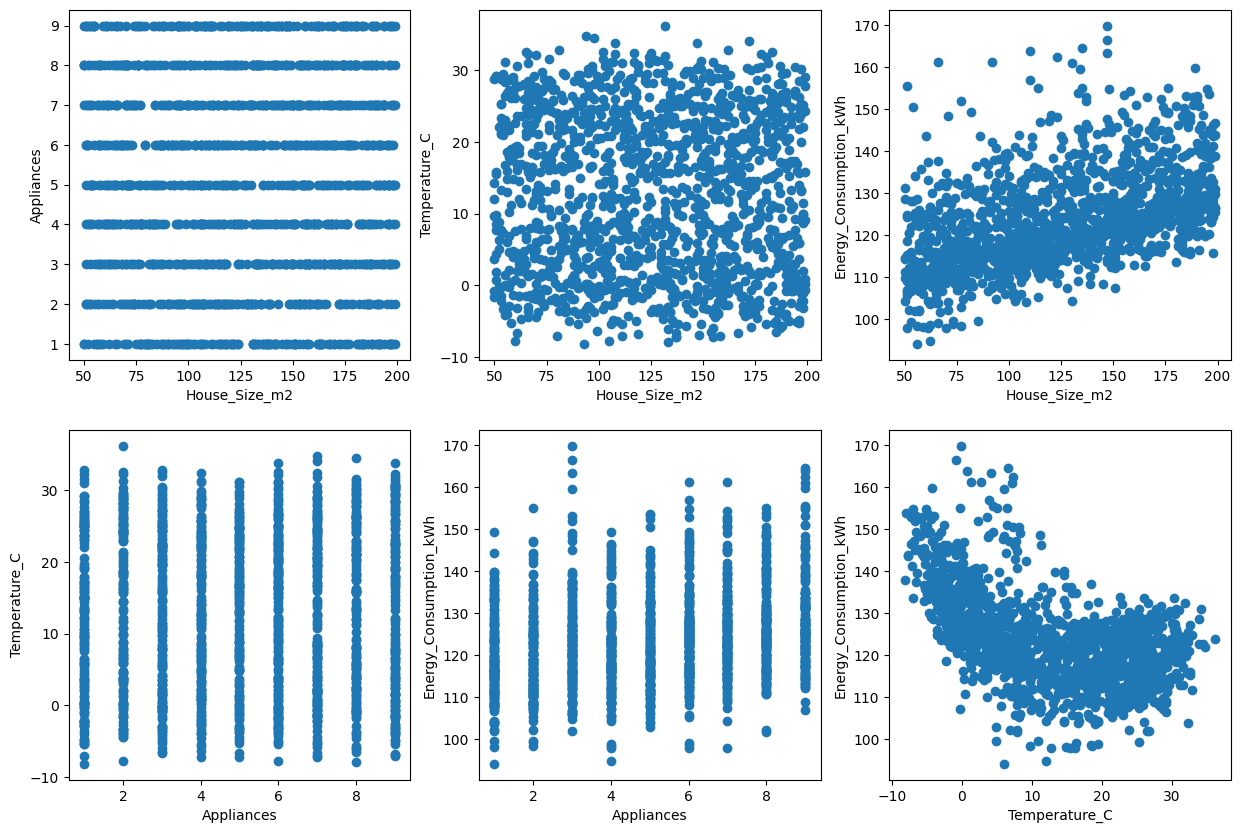

In [3]:
import itertools
import matplotlib.pyplot as plt

# create a list of all columns that we are considering
# features = [ 'age', 'temp', 'weight', 'length' ]
features = [ 'House_Size_m2', 'Appliances', 'Temperature_C', 'Energy_Consumption_kWh']

# create all combinations of considered columns
combinations = itertools.combinations(features, 2)

# create a figure and specify its size
fig = plt.figure(figsize=(15,10))

# go through all combinations and create one plot for each
figure_index = 1
for combination in combinations:
    # add a sub plot to the figure
    axs = fig.add_subplot(2,3,figure_index)
    
    # plot the feature combination
    # axs.scatter(fish[combination[0]], fish[combination[1]])
    axs.scatter(household_energy[combination[0]], household_energy[combination[1]])

    
    # set the axis labels of the current sub plot
    axs.set_xlabel(combination[0])
    axs.set_ylabel(combination[1])
        
    # increase the figure index (otherwise all plots are drawn in the first subplot)
    figure_index+=1

    
# show the plot
plt.show()

To work with the timestamps, it is usually easier to transform them into ordered indices.

In [4]:
# Convert the 'Date' column to an integer sequence, where the first date is 1
household_energy['Date'] = pd.to_datetime(household_energy['Date'])
household_energy['Date_as_int'] = (household_energy['Date'] - household_energy['Date'].min()).dt.days + 1
household_energy_IntDate = household_energy.drop(columns=['Date'])
household_energy_IntDate.head()

House_Size_m2  Appliances  Temperature_C  Energy_Consumption_kWh  \
0            109           6      -4.933628              139.060696   
1            157           6      -2.339252              140.634181   
2            106           1      -5.431556              132.958035   
3             80           1      -7.018320              133.571861   
4            133           3      -2.987828              135.371985   

   Date_as_int  
0            1  
1            2  
2            3  
3            4  
4            5

Let's plot house size, appliances, temperature, and energy consumption with respect to the timestamps and check whether some patterns arise.

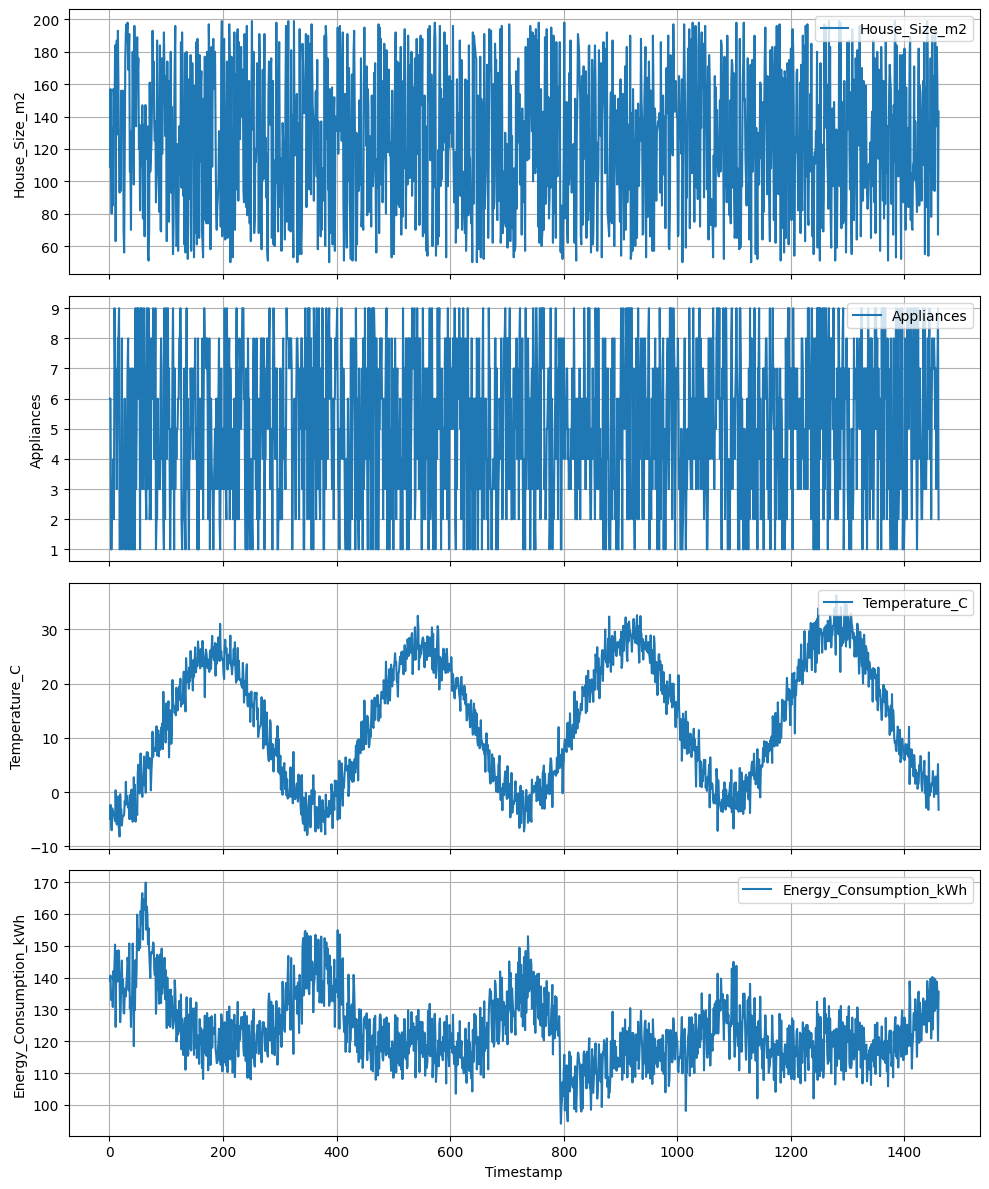

In [5]:
df = household_energy_IntDate.set_index('Date_as_int')


# Create a figure with subplots
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 12), sharex=True)

# List of the numeric feature columns
features = df.columns  # This will automatically include the 4 numeric columns

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    axs[i].plot(df.index, df[feature], label=feature)
    axs[i].set_ylabel(feature)
    axs[i].legend(loc="upper right")
    axs[i].grid(True)

# Set the x-axis label
plt.xlabel('Timestamp')

# Display the plots
plt.tight_layout()
plt.show()

### Core Ideas of Time Series Analysis

Time series data consists of observations collected over time, where the time-order of the data points plays a crucial role in identifying patterns and making predictions. Several key components often appear in time series data, each providing different insights:

#### 1. **Trend**
- A **trend** refers to the long-term movement or direction in the data over time.
- **Example**: Climate change leading to a steady increase in global temperatures over decades is an example of a positive trend.

  
#### 2. **Seasonality**
- **Seasonality** refers to periodic fluctuations in the data that repeat at regular intervals (e.g., daily, monthly, yearly).
- **Example**: The alternating pattern of hot summers and cold winters is an example of seasonality in temperature data.

#### 3. **Cyclicality**
- **Cyclicality** refers to longer-term fluctuations that do not follow a fixed frequency but are driven by broader factors, often external events.
- **Example**: The economic effects of the COVID-19 pandemic or the Ukraine war create cyclic patterns in global markets, with periods of recovery and contraction.

#### 4. **Randomness (Noise)**
- **Randomness** (also known as noise) represents the unpredictable, irregular variations in the data that cannot be explained by trends, seasonality, or cyclicality.
- **Example**: Daily fluctuations in stock prices or weather variations not tied to a clear cause.

---

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
# Create data points as before
n_points = 100
time = np.arange(n_points)

# Define components
trend_component = time * 1.5
seasonal_component = 30 * np.sin(time / 4)
cyclical_component = 20 * np.sin(time / 20)
random_component = np.random.normal(0, 5, n_points)

# Create individual series
trend = 100 + trend_component + np.random.normal(0, 3, n_points)
seasonality = 100 + seasonal_component + np.random.normal(0, 2, n_points)
cyclicality = 100 + cyclical_component + (time / 5) + np.random.normal(0, 3, n_points)
noise = 100 + random_component
combined = 100 + trend_component + seasonal_component + cyclical_component + random_component

# Create subplots
fig = make_subplots(rows=5, cols=1,
                   subplot_titles=("1. Trend", "2. Seasonality", "3. Cyclicality", 
                                   "4. Randomness (Noise)", "Combined Components: Full Time Series"))

# Add traces for each component
fig.add_trace(go.Scatter(x=time, y=trend, mode='lines', name='Trend', line=dict(color='#8884d8', width=2)), row=1, col=1)
fig.add_trace(go.Scatter(x=time, y=seasonality, mode='lines', name='Seasonality', line=dict(color='#82ca9d', width=2)), row=2, col=1)
fig.add_trace(go.Scatter(x=time, y=cyclicality, mode='lines', name='Cyclicality', line=dict(color='#8884d8', width=2)), row=3, col=1)
fig.add_trace(go.Scatter(x=time, y=noise, mode='lines', name='Noise', line=dict(color='#ff7300', width=2)), row=4, col=1)

# Add traces for combined view
fig.add_trace(go.Scatter(x=time, y=100 + trend_component, mode='lines', name='Trend Component', 
                        line=dict(color='#8884d8', width=1.5)), row=5, col=1)
fig.add_trace(go.Scatter(x=time, y=100 + trend_component + seasonal_component, mode='lines', 
                        name='Trend + Seasonal', line=dict(color='#82ca9d', width=1.5)), row=5, col=1)
fig.add_trace(go.Scatter(x=time, y=100 + trend_component + cyclical_component, mode='lines', 
                        name='Trend + Cyclical', line=dict(color='#ffc658', width=1.5)), row=5, col=1)
fig.add_trace(go.Scatter(x=time, y=combined, mode='lines', name='Complete Series', 
                        line=dict(color='#ff7300', width=3)), row=5, col=1)

# Update layout
fig.update_layout(height=1200, width=1200, showlegend=True)
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

# Show plot
fig.show()

### Time Series Decomposition

Time series data can often be decomposed into these components to better understand the underlying patterns. There are two primary approaches to time series decomposition:

#### 1. **Additive Model**
In an **additive model**, the time series is assumed to be the sum of its components:

$$
Y_t = T_t + S_t + C_t + R_t
$$

Where:
- $Y_t$ is the observed value at time $t$.
- $T_t$ is the trend component.
- $S_t$ is the seasonal component.
- $C_t$ is the cyclic component.
- $R_t$ is the residual (random noise).

This model assumes that the variations due to trend, seasonality, and cyclicality are constant over time.

**Example**: An additive model might work well for temperature data where the seasonal variation (difference between summer and winter) is consistent every year.

#### 2. **Multiplicative Model**
In a **multiplicative model**, the components are assumed to multiply together:

$$
Y_t = T_t \times S_t \times C_t \times R_t
$$

This model is suitable when variations grow or shrink over time in a proportional way.

**Example**: Sales of a product might exhibit multiplicative seasonality, where the effect of a holiday season increases sales more in years when the overall trend is higher.

---

#### When to Use Additive vs. Multiplicative Models

- **Additive models** are used when the magnitude of seasonal fluctuations and random variations are constant over time.
- **Multiplicative models** are used when seasonal fluctuations and variations increase or decrease in proportion to the trend.

Understanding the components of time series data and how to decompose them is essential for accurate forecasting and interpretation of long-term patterns. We can use the ***statsmodels*** package for this.


In [9]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

# Generate time series data
np.random.seed(42)
n_points = 144  # 12 years of monthly data

# Create a pandas DataFrame with DateTime index
start_date = datetime.datetime(2010, 1, 1)
dates = [start_date + datetime.timedelta(days=30*i) for i in range(n_points)]
years = np.arange(n_points) / 12

# Components for additive model
trend_linear = 10 + years * 5
seasonality = 10 * np.sin(np.arange(n_points) * 2 * np.pi / 12)
noise = np.random.normal(0, 1, n_points)
additive_series = trend_linear + seasonality + noise

# Components for multiplicative model
trend_exp = 10 + 2 * np.exp(years / 6)
seasonality_factor = 1 + 0.2 * np.sin(np.arange(n_points) * 2 * np.pi / 12)
noise_factor = 1 + 0.05 * np.random.normal(0, 1, n_points)
multiplicative_series = trend_exp * seasonality_factor * noise_factor

# Create DataFrames
df_add = pd.DataFrame({'value': additive_series}, index=dates)
df_mult = pd.DataFrame({'value': multiplicative_series}, index=dates)

# Use statsmodels for decomposition
decomposition_add = seasonal_decompose(df_add, model='additive', period=12)
decomposition_mult = seasonal_decompose(df_mult, model='multiplicative', period=12)

# Create comparison figure
fig_compare = make_subplots(rows=2, cols=1, 
                           subplot_titles=('Additive Model (Constant Variation)',
                                          'Multiplicative Model (Proportional Variation)'))

fig_compare.add_trace(go.Scatter(x=dates, y=additive_series, name='Additive', line=dict(color='blue')), row=1, col=1)
fig_compare.add_trace(go.Scatter(x=dates, y=multiplicative_series, name='Multiplicative', line=dict(color='red')), row=2, col=1)

fig_compare.update_layout(height=500, title_text="Comparing Additive vs. Multiplicative Time Series")

# Create additive decomposition figure
fig_add = make_subplots(rows=4, cols=1, 
                       subplot_titles=('Original Time Series',
                                     'Trend Component (T)',
                                     'Seasonal Component (S)',
                                     'Residual Component (R)'),
                       shared_xaxes=True,
                       vertical_spacing=0.05)

fig_add.add_trace(go.Scatter(x=dates, y=decomposition_add.observed, name='Original', line=dict(color='blue')), row=1, col=1)
fig_add.add_trace(go.Scatter(x=dates, y=decomposition_add.trend, name='Trend', line=dict(color='red')), row=2, col=1)
fig_add.add_trace(go.Scatter(x=dates, y=decomposition_add.seasonal, name='Seasonal', line=dict(color='green')), row=3, col=1)
fig_add.add_trace(go.Scatter(x=dates, y=decomposition_add.resid, name='Residual', line=dict(color='purple')), row=4, col=1)

fig_add.update_layout(height=800, title_text="Additive Time Series Decomposition: Y = T + S + R",
                    legend_tracegroupgap=180)

# Create multiplicative decomposition figure
fig_mult = make_subplots(rows=4, cols=1, 
                        subplot_titles=('Original Time Series',
                                      'Trend Component (T)',
                                      'Seasonal Component (S)',
                                      'Residual Component (R)'),
                        shared_xaxes=True,
                        vertical_spacing=0.05)

fig_mult.add_trace(go.Scatter(x=dates, y=decomposition_mult.observed, name='Original', line=dict(color='blue')), row=1, col=1)
fig_mult.add_trace(go.Scatter(x=dates, y=decomposition_mult.trend, name='Trend', line=dict(color='red')), row=2, col=1)
fig_mult.add_trace(go.Scatter(x=dates, y=decomposition_mult.seasonal, name='Seasonal', line=dict(color='green')), row=3, col=1)
fig_mult.add_trace(go.Scatter(x=dates, y=decomposition_mult.resid, name='Residual', line=dict(color='purple')), row=4, col=1)

fig_mult.update_layout(height=800, title_text="Multiplicative Time Series Decomposition: Y = T × S × R",
                     legend_tracegroupgap=180)

# Add annotations to explain the key differences
fig_compare.add_annotation(x=dates[72], y=max(additive_series)*0.9,
                          text="Constant seasonal variation",
                          showarrow=True,
                          arrowhead=1,
                          row=1, col=1)

fig_compare.add_annotation(x=dates[72], y=max(multiplicative_series)*0.9,
                          text="Proportional seasonal variation",
                          showarrow=True,
                          arrowhead=1,
                          row=2, col=1)

# Display figures
fig_compare.show()
fig_add.show()
fig_mult.show()

### --> The key difference you'll notice is that in the additive model, seasonal variations remain constant over time, while in the multiplicative model, they grow proportionally with the trend.

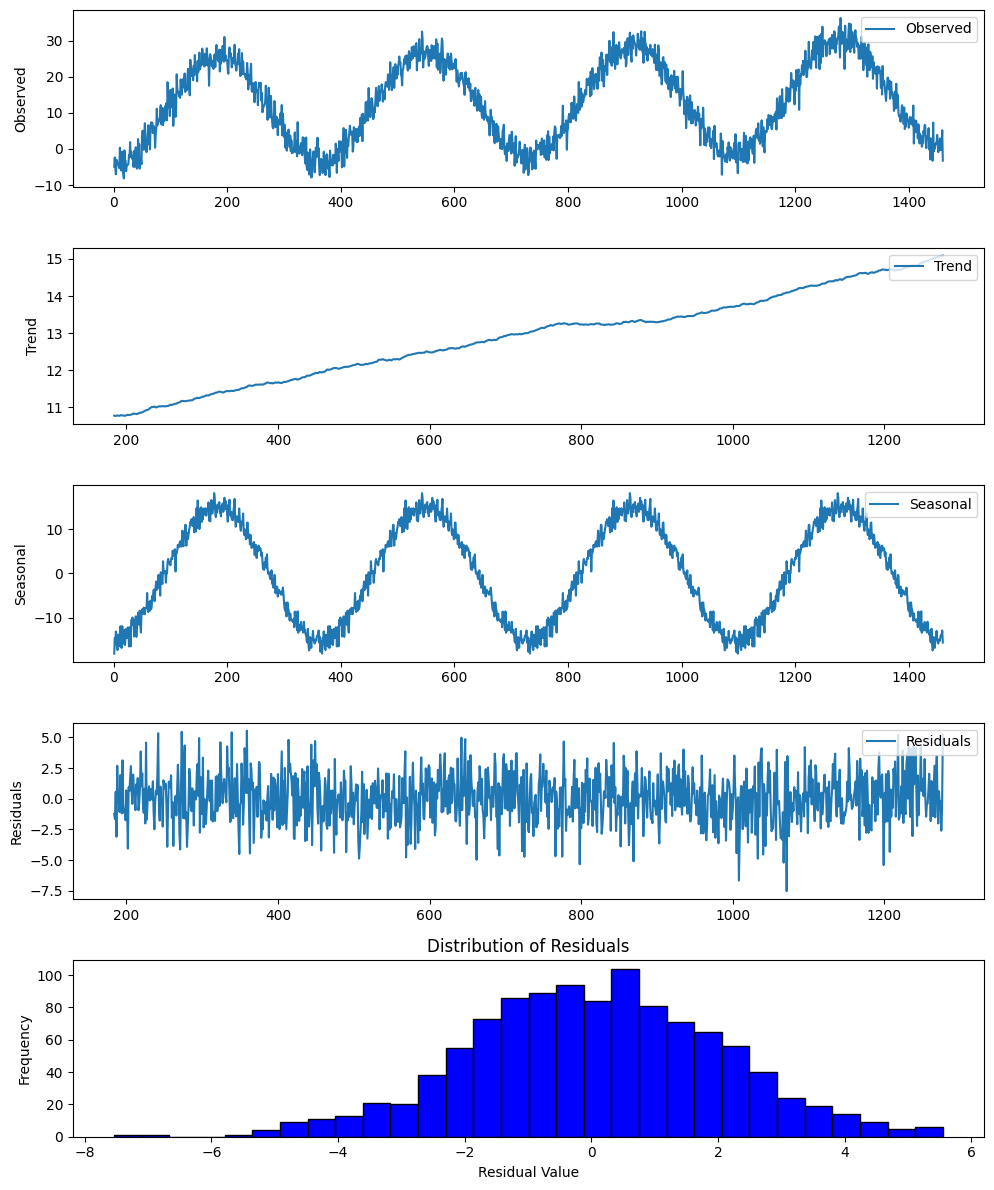

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# library for seasonal decomposition -> statsmodels

def decompose(data, period):
    # Decompose the time series using the seasonal_decompose function
    # Choose the 'Energy_Consumption_kWh' column as the series to decompose
    decomposition = seasonal_decompose(data, period=period)
    
    # Create subplots for the decomposition and residual histogram
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 12))
    
    # Plot the decomposed components
    axes[0].plot(decomposition.observed, label='Observed')
    axes[0].set_ylabel('Observed')
    axes[0].legend(loc='upper right')
    
    axes[1].plot(decomposition.trend, label='Trend')
    axes[1].set_ylabel('Trend')
    axes[1].legend(loc='upper right')
    
    axes[2].plot(decomposition.seasonal, label='Seasonal')
    axes[2].set_ylabel('Seasonal')
    axes[2].legend(loc='upper right')
    
    axes[3].plot(decomposition.resid, label='Residuals')
    axes[3].set_ylabel('Residuals')
    axes[3].legend(loc='upper right')
    
    # Extract the residuals and remove NaN values
    residuals = decomposition.resid.dropna()
    
    # Plot the histogram of residuals
    axes[4].hist(residuals, bins=30, color='blue', edgecolor='black')
    axes[4].set_ylabel('Frequency')
    axes[4].set_xlabel('Residual Value')
    axes[4].set_title('Distribution of Residuals')
    
    # Adjust the layout
    plt.tight_layout()
    plt.show()

decompose(data=df['Temperature_C'], period=366)


We can observe that the distribution of residuals follows an approximately bell-shaped curve centered near zero. The highest frequency occurs around the zero mark, with roughly symmetrical tapering on both sides. The distribution extends primarily between -5 and +5, with the majority of values concentrated between -2 and +2. 

We can observe a slight negative skew in the distribution, as evidenced by a slightly longer tail on the left side compared to the right. The overall shape indicates that most of the residuals represent small random variations after the trend and seasonal components were removed from the original time series. The near-normal distribution suggests that the decomposition has effectively captured the systematic patterns in the data, leaving primarily random noise in the residuals.

We can also observe that there are no major outliers or secondary peaks in the distribution, which would have indicated periods where the model failed to adequately capture the underlying patterns in the data.

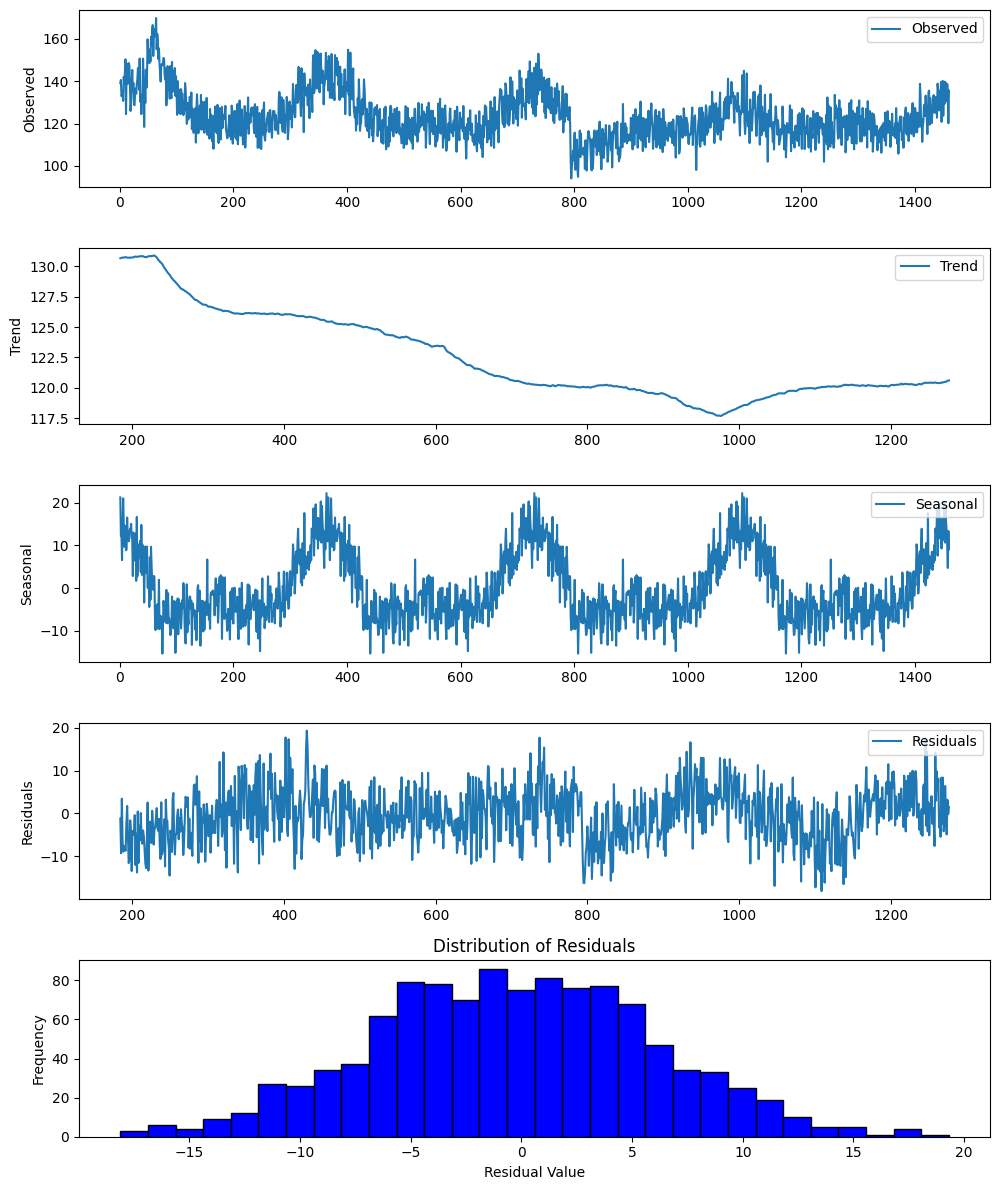

In [11]:
decompose(df['Energy_Consumption_kWh'], period=366)

We can observe that the distribution of residuals displays a roughly symmetrical bell-shaped pattern centered around zero. The frequency peaks near the zero mark and gradually decreases on both sides. The residual values primarily fall within the range of -15 to +15, with the majority concentrated between -5 and +5.

We can observe that the distribution appears approximately normal, which suggests that the time series decomposition has successfully captured the systematic components (trend and seasonality) of the data. The residuals represent the random variation that remains after accounting for these components.

We can observe that the distribution appears slightly wider than in the previous example, indicating a higher degree of random variability in this time series. This is consistent with the residuals plot above, which shows fluctuations with greater amplitude.

We can observe no significant skewness in the distribution, as both tails extend roughly equally, suggesting that the model doesn't systematically over-predict or under-predict values across the time series.

### How to Pick the Seasonality Parameter in Time Series Decomposition

When performing time series decomposition using methods like `seasonal_decompose`, one of the key parameters you need to define is the **seasonality parameter**, often referred to as the **period**. The period is the number of time steps that define a complete seasonal cycle. Choosing the correct period is crucial for accurate decomposition and interpretation of seasonal components.

#### 1. **Understand the Nature of Your Data**

Before selecting a seasonality parameter, consider the type of data you are working with and what a "season" means in that context. Here are some examples:

- **Daily Data**: If you have daily data, the seasonality could reflect weekly patterns (a period of 7 days) or yearly patterns (a period of 365 days).
- **Monthly Data**: For monthly data, a common period would be 12 months to capture yearly seasonality.
- **Quarterly Data**: If your data is collected on a quarterly basis, the period could be 4 (4 quarters in a year).

#### 2. **Domain Knowledge**

Leverage **domain knowledge** to make an informed choice about the period. Ask yourself the following questions:
- Does the data exhibit cycles that repeat annually, monthly, or weekly?
- Are there specific business cycles (e.g., quarterly sales reports, holiday seasons) that recur at predictable intervals?

For instance, in climate data, a period of 12 months might make sense to capture the effect of seasons, whereas in retail sales, there might be cycles related to major holidays or events (e.g., Black Friday).

#### 3. **Visual Inspection of the Data**

Before setting a seasonality parameter, it can be helpful to **plot the time series** and visually inspect the data for repeating patterns. Plotting the data helps to detect regular intervals at which peaks or troughs occur, giving you clues about the period.

If you are unsure about the period, you can use statistical tools such as the ***Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)*** to identify ***potential seasonality***. These functions measure how correlated the time series is with its past values, and seasonal peaks often appear as significant spikes at lags corresponding to the seasonal period.


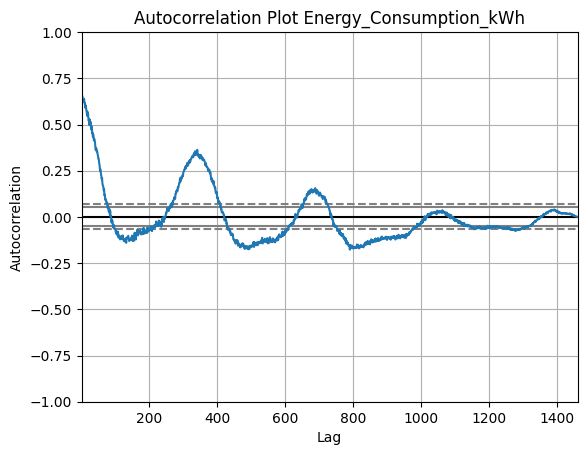

In [12]:
from pandas.plotting import autocorrelation_plot

# Example: Plot autocorrelation
autocorrelation_plot(df['Energy_Consumption_kWh'])
plt.title('Autocorrelation Plot Energy_Consumption_kWh')
plt.show()

### A quick note on lag

Lag in time series analysis represents the time difference between data points being compared, with lag 1 comparing each point to its immediate predecessor. In autocorrelation plots, the x-axis shows different lag values while the y-axis displays correlation coefficients between the original series and its lagged version. Strong correlation at specific lags (like 7 for weekly patterns or 365 for annual patterns) reveals underlying seasonal cycles in the data. The autocorrelation plot for the energy consumption data shows significant peaks at lags 350-360, indicating an annual seasonal pattern if the data is recorded daily. Identifying these natural cycles through autocorrelation analysis helps determine the appropriate seasonality parameter for time series decomposition.

In [13]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a synthetic time series with yearly seasonality (365 days)
def create_seasonal_data(days=1095):  # 3 years of data
    # Date range
    dates = pd.date_range(start='2020-01-01', periods=days)
    
    # Yearly seasonal pattern (365 days)
    seasonal = 15 * np.sin(2 * np.pi * np.arange(days) / 365)
    
    # Add some noise and trend
    noise = np.random.normal(0, 2, days)
    trend = np.linspace(50, 70, days)
    
    # Combine components
    values = trend + seasonal + noise
    
    return pd.Series(values, index=dates)

# Create data
data = create_seasonal_data()

# Create figure with sliders
fig = make_subplots(rows=2, cols=1, 
                    shared_xaxes=False,
                    vertical_spacing=0.1,
                    subplot_titles=("Original Time Series", "Original vs. Lagged Series"),
                    row_heights=[0.4, 0.6])

# Add original time series
fig.add_trace(
    go.Scatter(x=data.index, y=data, mode='lines', name='Original Series'),
    row=1, col=1
)

# Create empty traces for the overlay plot (will be updated by the slider)
fig.add_trace(
    go.Scatter(x=data.index, y=data, mode='lines', name='Original', line=dict(color='blue')),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=data.index, y=data, mode='lines', name='Lagged (365 days)', 
               line=dict(color='red', dash='dash')),
    row=2, col=1
)

# Add annotation for correlation value
fig.add_annotation(
    x=0.5, y=0.55,
    xref="paper", yref="paper",
    text=f"Correlation at lag 365: {np.corrcoef(data[365:], data[:-365])[0,1]:.3f}",
    showarrow=False,
    font=dict(size=14)
)

# Update layout
fig.update_layout(
    title="Understanding Lag in Time Series",
    height=700,
    sliders=[{
        'active': 365,
        'currentvalue': {"prefix": "Lag: "},
        'pad': {"t": 50},
        'steps': [
            {
                'method': 'update',
                'label': str(lag),
                'args': [
                    {
                        'y': [
                            data,  # Original time series (unchanged)
                            data,  # Original series for comparison
                            data.shift(lag)  # Shifted series based on lag
                        ],
                        'name': [
                            'Original Series',
                            'Original',
                            f'Lagged ({lag} days)'
                        ]
                    },
                    {
                        'annotations': [{
                            'x': 0.5, 'y': 0.55,
                            'xref': "paper", 'yref': "paper",
                            'text': f"Correlation at lag {lag}: {np.corrcoef(data[lag:], data[:-lag])[0,1]:.3f}" if lag < len(data) else "Lag too large",
                            'showarrow': False,
                            'font': {'size': 14}
                        }]
                    }
                ]
            } for lag in range(1, 731, 30)  # Lags from 1 to 730 (2 years) in steps of 30
        ]
    }]
)

fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)

fig.show()

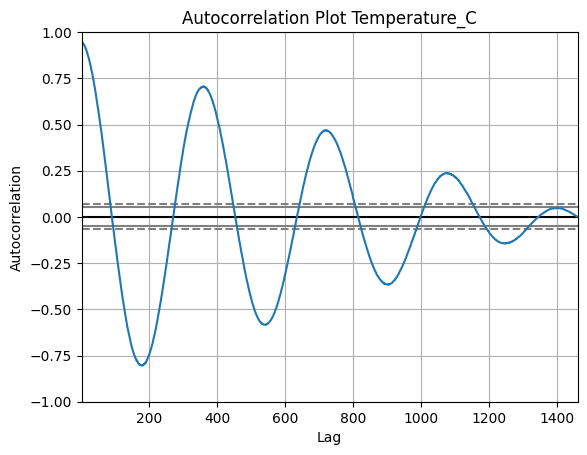

In [14]:
from pandas.plotting import autocorrelation_plot

# Example: Plot autocorrelation
autocorrelation_plot(df['Temperature_C'])
plt.title('Autocorrelation Plot Temperature_C')
plt.show()

### What Do Positive and Negative Peaks Indicate?

#### Positive Peaks:
A **positive peak** at a given lag indicates that there is a **positive correlation** between the time series values that are separated by that lag. This means that when the value at time $t$ is high, the value at time $t - \text{lag}$ tends to be high as well, and vice versa for low values.

**Example**: A positive peak at lag 12 in monthly data may indicate a yearly pattern where high values repeat every 12 months.

#### Negative Peaks:
A **negative peak** indicates a **negative correlation** between values at the given lag. This means that when the value at time $t$ is high, the value at time $t - \text{lag}$ tends to be low, and vice versa. Negative correlations can often signify a reversing pattern or seasonal oscillation.

**Example**: A negative peak at lag 6 in monthly data might indicate that high values tend to be followed by low values 6 months later (e.g., summer temperatures followed by winter).

---

### How to Interpret Both Positive and Negative Peaks

#### Positive Peaks:
Indicate repeated patterns of similar direction at a certain lag.

**Example**: If sales data has a strong positive peak at lag 12 in monthly data, it could indicate that sales spike every December.

#### Negative Peaks:
Indicate patterns where high values are followed by low values (or vice versa) at a certain lag.

**Example**: In seasonal temperature data, if there’s a negative peak at lag 6, it could suggest that summer temperatures are negatively correlated with winter temperatures six months later.

---

### How to Use Positive and Negative Peaks in Practice

#### 1. **Seasonality Detection**:
- **Positive Peaks**: If there’s a significant positive peak at lag $s$ in the ACF plot, this could indicate seasonality with a period of $s$. For instance, in monthly data, a positive peak at lag 12 suggests yearly seasonality.
- **Negative Peaks**: These may appear between seasonal peaks, especially when there's an oscillating pattern (e.g., higher values in summer and lower values in winter).

#### 2. **Cyclic or Oscillating Patterns**:
Repeated cycles of positive and negative peaks at regular intervals can indicate cyclic patterns. For example, alternating positive and negative peaks every 6 months might reflect a seasonal pattern in temperature (hot summer, cold winter).

#### 3. **Trend Analysis**:
In trending data, you may observe decaying positive autocorrelations at shorter lags (e.g., lag 1, lag 2, lag 3), followed by insignificant correlations at larger lags. ACF patterns like this suggest the presence of a trend.


In [15]:
from statsmodels.tsa.stattools import acf

# Create synthetic ski resort sales data (5 years of monthly data)
def create_ski_resort_data(months=60):
    # Date range (monthly data)
    dates = pd.date_range(start='2018-01-01', periods=months, freq='M')
    
    # Seasonal pattern (high in winter, low in summer)
    time_index = np.arange(months)
    # Create seasonality where December-February have high values, June-August have low values
    seasonal = -20 * np.cos(2 * np.pi * time_index / 12)
    
    # Add yearly growth trend
    trend = np.linspace(0, 10, months)
    
    # Add some random variation
    noise = np.random.normal(0, 3, months)
    
    # Combine components (scale up to realistic sales numbers)
    values = 50 + trend + seasonal + noise
    
    # Ski resorts have near-zero sales in summer, so apply a floor
    values = np.maximum(values, 5)
    
    return pd.Series(values, index=dates)

# Create data
ski_sales = create_ski_resort_data()

# Calculate autocorrelation function properly using statsmodels
max_lag = 36
acf_values = acf(ski_sales, nlags=max_lag, fft=True)

# Create figure with sliders
fig = make_subplots(rows=3, cols=1, 
                    shared_xaxes=False,
                    vertical_spacing=0.1,
                    subplot_titles=("Ski Resort Monthly Sales", 
                                   "Original vs. Lagged Series", 
                                   "Autocorrelation Function"),
                    row_heights=[0.3, 0.4, 0.3])

# Add original time series
fig.add_trace(
    go.Scatter(x=ski_sales.index, y=ski_sales, mode='lines', name='Monthly Sales',
              line=dict(color='blue')),
    row=1, col=1
)

# Create empty traces for the overlay plot (will be updated by the slider)
fig.add_trace(
    go.Scatter(x=ski_sales.index, y=ski_sales, mode='lines', name='Original', 
              line=dict(color='blue')),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=ski_sales.index, y=ski_sales.shift(12), mode='lines', 
               name='Lagged (12 months)', line=dict(color='red', dash='dash')),
    row=2, col=1
)

# Add autocorrelation plot - fixed to not be affected by slider
fig.add_trace(
    go.Scatter(x=np.arange(len(acf_values)), y=acf_values, mode='lines+markers',
              name='Autocorrelation', line=dict(color='green')),
    row=3, col=1
)

# Add a marker to highlight the current lag on the ACF plot - this will be updated by the slider
fig.add_trace(
    go.Scatter(x=[12], y=[acf_values[12]], mode='markers', 
               name='Current Lag', marker=dict(color='red', size=12, symbol='circle-open')),
    row=3, col=1
)

# Add confidence interval lines for ACF
conf_level = 1.96 / np.sqrt(len(ski_sales))
fig.add_trace(
    go.Scatter(x=np.arange(len(acf_values)), y=[conf_level] * len(acf_values),
              mode='lines', name='95% Confidence', line=dict(color='gray', dash='dash')),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(acf_values)), y=[-conf_level] * len(acf_values),
              mode='lines', name='95% Confidence', line=dict(color='gray', dash='dash'),
              showlegend=False),
    row=3, col=1
)

# Initial lag and correlation
initial_lag = 12
initial_corr = np.corrcoef(ski_sales[initial_lag:], ski_sales[:-initial_lag])[0,1]

# Add annotation for correlation value
fig.add_annotation(
    x=0.5, y=0.45,
    xref="paper", yref="paper",
    text=f"Correlation at lag {initial_lag}: {initial_corr:.3f}",
    showarrow=False,
    font=dict(size=14)
)

# Highlight key lags in ACF
fig.add_annotation(
    x=12, y=acf_values[12],
    text="Yearly Pattern (Lag 12)",
    showarrow=True,
    arrowhead=1,
    row=3, col=1
)

fig.add_annotation(
    x=6, y=acf_values[6],
    text="Negative Correlation (Lag 6)",
    showarrow=True,
    arrowhead=1,
    row=3, col=1
)

# Slider steps
slider_steps = []
for lag in range(1, 25):  # Lags from 1 to 24 months
    if lag < len(ski_sales):
        corr = np.corrcoef(ski_sales[lag:], ski_sales[:-lag])[0,1]
        step = {
            'method': 'update',
            'label': str(lag),
            'args': [
                {
                    'y': [
                        ski_sales,  # Original sales data (unchanged)
                        ski_sales,  # Original series for comparison
                        ski_sales.shift(lag),  # Shifted series based on lag
                        acf_values,  # ACF values (unchanged)
                        [acf_values[lag]]  # Update marker position
                    ],
                    'x': [
                        ski_sales.index,  # Original sales data (unchanged)
                        ski_sales.index,  # Original series for comparison
                        ski_sales.index,  # Shifted series based on lag
                        np.arange(len(acf_values)),  # ACF x values (unchanged)
                        [lag]  # Update marker position
                    ]
                },
                {
                    'annotations': [{
                        'x': 0.5, 'y': 0.45,
                        'xref': "paper", 'yref': "paper",
                        'text': f"Correlation at lag {lag}: {corr:.3f}",
                        'showarrow': False,
                        'font': {'size': 14}
                    }]
                }
            ]
        }
        slider_steps.append(step)

# Update layout
fig.update_layout(
    title="Ski Resort Sales: Identifying Seasonality through Lag Analysis",
    height=900,
    sliders=[{
        'active': 11,  # Default to yearly lag (0-indexed)
        'currentvalue': {"prefix": "Lag: "},
        'pad': {"t": 50},
        'steps': slider_steps
    }]
)

# Add horizontal line at y=0 for the ACF plot
fig.add_shape(
    type="line", line=dict(color="black", width=1),
    x0=0, x1=max_lag, y0=0, y1=0,
    row=3, col=1
)

# Axis labels
fig.update_yaxes(title_text="Sales ($1000s)", row=1, col=1)
fig.update_yaxes(title_text="Sales ($1000s)", row=2, col=1)
fig.update_yaxes(title_text="Correlation", range=[-1.1, 1.1], row=3, col=1)
fig.update_xaxes(title_text="Month", row=2, col=1)
fig.update_xaxes(title_text="Lag (months)", row=3, col=1)

fig.show()

/tmp/ipykernel_5780/3785619489.py:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



### Moving Averages for Data Smoothing

**Moving Averages (MA)** are a simple yet powerful technique used to smooth time series data by reducing noise and short-term fluctuations, making it easier to observe long-term trends. 

#### What is a Moving Average?

A **moving average** is calculated by taking the average of a fixed number of consecutive data points (the "window") and then sliding that window across the time series. At each step, the average of the window is computed and becomes the new smoothed data point. There are different types of moving averages:

- **Simple Moving Average (SMA)**: 
  $$
  \text{SMA}_t = \frac{y_t + y_{t-1} + \dots + y_{t-n+1}}{n}
  $$
  Where $y_t$ is the value at time $t$, and $n$ is the size of the window. The SMA gives equal weight to all points within the window.

- **Exponential Moving Average (EMA)**:
  $$
  \text{EMA}_t = \alpha \cdot y_t + (1 - \alpha) \cdot \text{EMA}_{t-1}
  $$
  Where $\alpha$ is the smoothing factor (typically $\alpha = \frac{2}{n+1}$ for an $n$-period EMA). EMA gives more weight to recent observations, making it more responsive to recent changes in the data.

#### Why is Smoothing Needed?

Smoothing time series data with moving averages is important for several reasons:

1. **Reducing Noise**: Time series data can be noisy, with short-term fluctuations obscuring the underlying trend. Smoothing reduces this noise and helps highlight important patterns.
   
2. **Revealing Trends**: By smoothing the data, long-term trends, seasonality, and cycles become easier to identify and analyze. This is particularly useful in fields like finance, sales forecasting, and weather analysis.

3. **Improving Forecasting**: Smoothing can help improve the accuracy of forecasting models by focusing on the long-term pattern of the data, rather than reacting to short-term variations.

#### Example:

Imagine you're analyzing daily sales data. The sales fluctuate significantly from day to day due to various factors (promotions, weather, holidays), making it hard to see the overall trend. By applying a moving average, you can smooth out these daily fluctuations and observe a clearer trend of how sales are changing over time.

In summary, **moving averages** help to reduce the noise in data, reveal long-term trends, and are often the first step in more advanced time series analysis.


In [16]:
# Function to generate synthetic daily sales data with noise
def create_noisy_sales_data(days=365*2):  # 2 years of daily data
    # Date range
    dates = pd.date_range(start='2022-01-01', periods=days)
    
    # Time index
    time_index = np.arange(days)
    
    # Multiple components
    # Long-term trend
    trend = 100 + time_index * 0.05
    
    # Yearly seasonality
    yearly_seasonal = 30 * np.sin(2 * np.pi * time_index / 365)
    
    # Weekly seasonality (weekends higher)
    weekly_pattern = np.zeros(days)
    for i in range(days):
        # Higher values on weekends (day 5 and 6 in zero-indexed week)
        if i % 7 == 5 or i % 7 == 6:
            weekly_pattern[i] = 15
    
    # Add substantial noise to make smoothing necessary
    noise = np.random.normal(0, 15, days)
    
    # Combine components
    values = trend + yearly_seasonal + weekly_pattern + noise
    
    return pd.Series(values, index=dates)

# Create data
daily_sales = create_noisy_sales_data()

# Function to apply Simple Moving Average (SMA)
def apply_sma(data, window):
    return data.rolling(window=window, center=True).mean()

# Calculate initial smoothed series with window=7 (weekly)
initial_window = 7
smoothed_sales = apply_sma(daily_sales, initial_window)

# Create figure with sliders
fig = make_subplots(rows=1, cols=1,
                    subplot_titles=("Daily Sales Data with Moving Average Smoothing"))

# Add the original noisy data
fig.add_trace(
    go.Scatter(x=daily_sales.index, y=daily_sales, mode='lines', 
               name='Raw Daily Sales', line=dict(color='lightgray', width=1))
)

# Add smoothed data
fig.add_trace(
    go.Scatter(x=smoothed_sales.index, y=smoothed_sales, mode='lines', 
               name=f'{initial_window}-Day Moving Average', line=dict(color='blue', width=3))
)

# Calculate available moving average windows
window_options = [1, 3, 7, 14, 30, 60, 90, 180, 365]

# Create slider steps
slider_steps = []
for window in window_options:
    smoothed = apply_sma(daily_sales, window)
    step = {
        'method': 'update',
        'label': str(window),
        'args': [
            {
                'y': [daily_sales, smoothed]
            },
            {
                'traces': [0, 1],
                'name': [f'Raw Daily Sales', f'{window}-Day Moving Average']
            }
        ]
    }
    slider_steps.append(step)

# Update layout
fig.update_layout(
    title="Effect of Moving Average Window Size on Data Smoothing",
    height=600,
    width=1000,
    xaxis_title="Date",
    yaxis_title="Sales",
    hovermode="x unified",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    sliders=[{
        'active': window_options.index(initial_window),
        'currentvalue': {"prefix": "Window Size: ", "suffix": " days"},
        'pad': {"t": 50},
        'steps': slider_steps
    }]
)

# Add annotation to explain the effect
fig.add_annotation(
    x=0.5, y=0.05,
    xref="paper", yref="paper",
    text="Drag the slider to change the moving average window size.<br>Larger windows create smoother trends but introduce more lag.",
    showarrow=False,
    font=dict(size=12),
    align="center",
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="gray",
    borderwidth=1,
    borderpad=4
)

fig.show()

# For comparison, create a second visualization showing multiple smoothing levels at once
fig2 = go.Figure()

# Add original data
fig2.add_trace(
    go.Scatter(x=daily_sales.index, y=daily_sales, mode='lines', 
               name='Raw Data', line=dict(color='lightgray', width=1))
)

# Add different smoothing levels
window_sizes = [7, 30, 90, 365]
colors = ['blue', 'green', 'red', 'purple']

for i, window in enumerate(window_sizes):
    smoothed = apply_sma(daily_sales, window)
    fig2.add_trace(
        go.Scatter(x=smoothed.index, y=smoothed, mode='lines', 
                   name=f'{window}-Day MA', line=dict(color=colors[i], width=2))
    )

fig2.update_layout(
    title="Comparison of Different Moving Average Window Sizes",
    height=600,
    width=1000,
    xaxis_title="Date",
    yaxis_title="Sales",
    hovermode="x unified",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig2.show()

In [17]:
# Try to use existing df variable with Energy_Consumption_kWh column
energy_data = df['Energy_Consumption_kWh']

# Function to apply Simple Moving Average (SMA)
def apply_sma(data, window):
    return data.rolling(window=window, center=True).mean()

# Initial window size (80 as in your example)
initial_window = 80
smoothed_energy = apply_sma(energy_data, initial_window)

# Create figure for interactive visualization
fig = go.Figure()

# Add original data
fig.add_trace(
    go.Scatter(x=energy_data.index, y=energy_data, mode='lines', 
               name='Original Energy Consumption', line=dict(color='blue', width=1))
)

# Add smoothed data
fig.add_trace(
    go.Scatter(x=smoothed_energy.index, y=smoothed_energy, mode='lines', 
               name=f'{initial_window}-Point Moving Average', line=dict(color='red', width=2))
)

# Define window size options
# Using logarithmic scale for window sizes to cover a wide range
window_options = [1, 5, 10, 20, 40, 80, 160, 240, 320, 480]

# Create slider steps
slider_steps = []
for window in window_options:
    smoothed = apply_sma(energy_data, window)
    step = {
        'method': 'update',
        'label': str(window),
        'args': [
            {
                'y': [energy_data, smoothed]
            },
            {
                'traces': [0, 1],
                'name': [f'Original Energy Consumption', f'{window}-Point Moving Average']
            }
        ]
    }
    slider_steps.append(step)

# Update layout
fig.update_layout(
    title="Energy Consumption Smoothing with Adjustable Moving Average Window",
    height=600,
    width=1000,
    xaxis_title="Timestamp",
    yaxis_title="Energy Consumption (kWh)",
    hovermode="x unified",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    sliders=[{
        'active': window_options.index(initial_window),
        'currentvalue': {"prefix": "Window Size: ", "suffix": " points"},
        'pad': {"t": 50},
        'steps': slider_steps
    }]
)

# Add annotation to explain the effect
fig.add_annotation(
    x=0.5, y=0.05,
    xref="paper", yref="paper",
    text="Drag the slider to change the moving average window size.<br>Larger windows create smoother trends but reduce responsiveness to recent changes.",
    showarrow=False,
    font=dict(size=12),
    align="center",
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="gray",
    borderwidth=1,
    borderpad=4
)

# Create comparison visualization with multiple window sizes
fig2 = go.Figure()

# Add original data
fig2.add_trace(
    go.Scatter(x=energy_data.index, y=energy_data, mode='lines', 
               name='Original Data', line=dict(color='blue', width=1))
)

# Add different smoothing levels
comparison_windows = [10, 40, 80, 240]
colors = ['red', 'orange', 'green', 'purple']

for i, window in enumerate(comparison_windows):
    smoothed = apply_sma(energy_data, window)
    fig2.add_trace(
        go.Scatter(x=smoothed.index, y=smoothed, mode='lines', 
                   name=f'{window}-Point MA', line=dict(color=colors[i], width=2))
    )

fig2.update_layout(
    title="Comparison of Different Moving Average Window Sizes for Energy Consumption",
    height=600,
    width=1000,
    xaxis_title="Timestamp",
    yaxis_title="Energy Consumption (kWh)",
    hovermode="x unified",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Show figures
fig.show()
fig2.show()

### As a reminder, before, our decomposition for energy consumption still contained a lot of noise after decomposition.

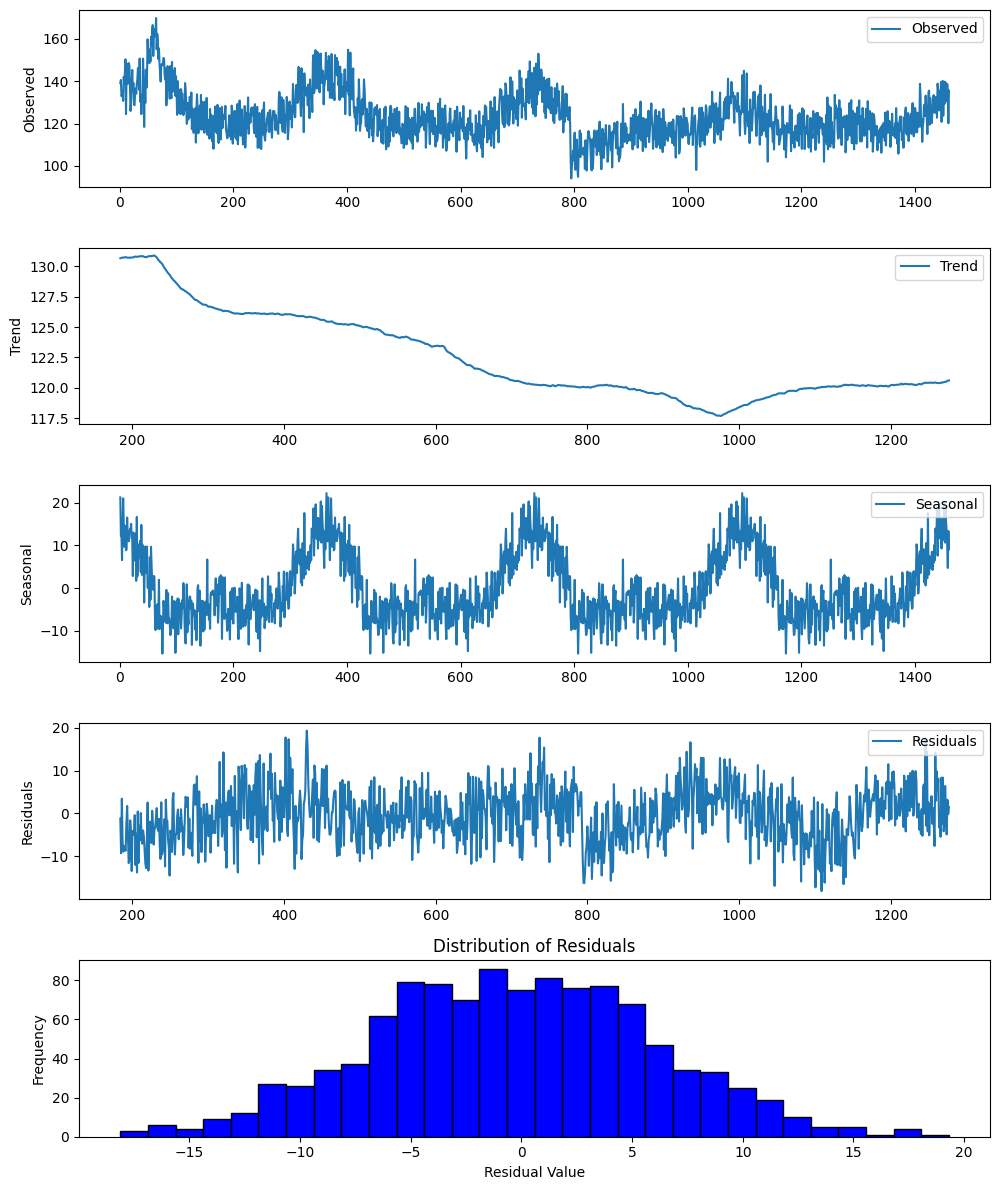

In [18]:

decompose(df['Energy_Consumption_kWh'], period=366)

### Let's see whether the smoothing of the data affects the decomposition into trend seasonality, and residuals.

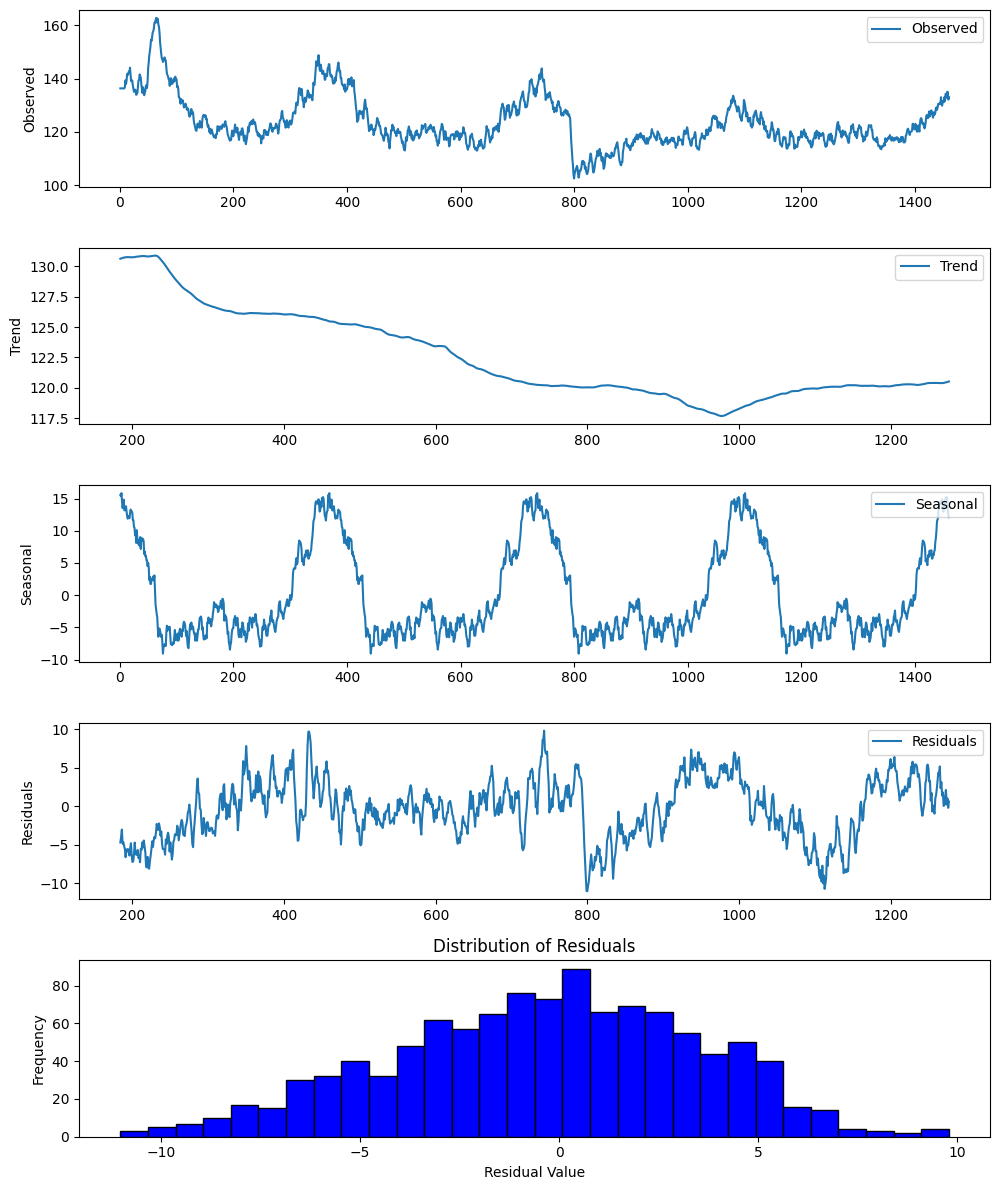

In [19]:

temperature_C_SMA = df['Energy_Consumption_kWh'].rolling(window=7).mean()

temperature_filled = temperature_C_SMA.bfill()

decompose(temperature_filled, period=366)

## Stationarity in Time Series Analysis

Stationarity is a fundamental concept in time series analysis. A stationary time series has statistical properties that do not change over time - specifically:

1. **Constant Mean**: The average value remains consistent over time
2. **Constant Variance**: The variation around the mean doesn't change over time
3. **Constant Autocorrelation Structure**: The correlation between observations at different time lags remains constant

Stationarity is crucial because:
- Most time series models (including ARIMA) assume the data is stationary
- It allows us to make reliable predictions since the underlying statistical properties aren't changing
- It simplifies the mathematical treatment of the series

### Types of Non-Stationarity

1. **Trend Non-Stationarity**: The series has an upward or downward trend over time
2. **Seasonal Non-Stationarity**: The series shows regular patterns at specific time intervals
3. **Variance Non-Stationarity**: The variability of the series changes over time

### Differencing to Achieve Stationarity

Differencing is the primary technique used in ARIMA models to transform a non-stationary series into a stationary one. The "I" (Integrated) component in ARIMA indicates how many times differencing is applied.

**First-order differencing** (d=1) computes the difference between consecutive observations:
$$y'_t = y_t - y_{t-1}$$

**Second-order differencing** (d=2) applies differencing twice:
$$y''_t = y'_t - y'_{t-1} = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) = y_t - 2y_{t-1} + y_{t-2}$$

**Seasonal differencing** computes the difference between observations at seasonal intervals:
$$y'_t = y_t - y_{t-s}$$
where s is the seasonal period (e.g., 12 for monthly data with yearly seasonality).



In [20]:
from statsmodels.tsa.stattools import adfuller

# Set random seed for reproducibility
np.random.seed(42)

# Create time array
time = np.arange(0, 200)

# 1. Generate a stationary time series (white noise)
stationary_series = np.random.normal(loc=10, scale=2, size=len(time))

# 2. Generate a series with trend (non-stationary)
trend = 0.05 * time
trend_series = 10 + trend + np.random.normal(loc=0, scale=2, size=len(time))

# 3. Generate a series with seasonality (non-stationary)
seasonal_component = 5 * np.sin(2 * np.pi * time / 20)
seasonal_series = 10 + seasonal_component + np.random.normal(loc=0, scale=1, size=len(time))

# 4. Generate a series with both trend and seasonality
trend_seasonal_series = 10 + trend + seasonal_component + np.random.normal(loc=0, scale=1, size=len(time))

# 5. Generate a series with changing variance (non-stationary)
variance_series = 10 + np.random.normal(loc=0, scale=1+time/50, size=len(time))

# Create a dictionary of series for easier handling
series_dict = {
    "Stationary (White Noise)": stationary_series,
    "Trend (Non-stationary)": trend_series,
    "Seasonal (Non-stationary)": seasonal_series,
    "Trend + Seasonal (Non-stationary)": trend_seasonal_series,
    "Changing Variance (Non-stationary)": variance_series
}

# Function to apply differencing
def difference_series(series, order=1):
    """Apply differencing of specified order to a series"""
    diff_series = series.copy()
    for i in range(order):
        diff_series = np.diff(diff_series)
    return diff_series

# Create interactive plot
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=("Original Time Series", "After Differencing"),
                    vertical_spacing=0.15,
                    row_heights=[0.5, 0.5])

# Add traces for each series
for name, series in series_dict.items():
    fig.add_trace(
        go.Scatter(x=time, y=series, name=name, visible=(name=="Trend (Non-stationary)")),
        row=1, col=1
    )
    
    # Add differenced series (first order)
    diff_series = difference_series(series)
    fig.add_trace(
        go.Scatter(x=time[1:], y=diff_series, name=f"{name} (Differenced)",
                 visible=(name=="Trend (Non-stationary)")),
        row=2, col=1
    )

# Create buttons for each series type
buttons = []
for i, name in enumerate(series_dict.keys()):
    visibility = [False] * len(series_dict) * 2  # Two traces per series
    visibility[i] = True  # Original series
    visibility[i + len(series_dict)] = True  # Differenced series
    
    button = dict(
        label=name,
        method="update",
        args=[{"visible": visibility},
              {"title": f"Stationarity Demonstration: {name}"}]
    )
    buttons.append(button)

# Add dropdown menu
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1,
        'y': 1.15,
    }]
)

# Add ADF test results annotation
adf_results = {}
for name, series in series_dict.items():
    # Run ADF test on original
    orig_result = adfuller(series)
    orig_pvalue = orig_result[1]
    orig_stationary = orig_pvalue < 0.05
    
    # Run ADF test on differenced
    diff_result = adfuller(difference_series(series))
    diff_pvalue = diff_result[1]
    diff_stationary = diff_pvalue < 0.05
    
    adf_results[name] = {
        'original': {'pvalue': orig_pvalue, 'stationary': orig_stationary},
        'differenced': {'pvalue': diff_pvalue, 'stationary': diff_stationary}
    }

# Format the results as an annotation
adf_text = "Trend (Non-stationary):<br>"
adf_text += f"  Original: {'Stationary' if adf_results['Trend (Non-stationary)']['original']['stationary'] else 'Non-stationary'} (p-value: {adf_results['Trend (Non-stationary)']['original']['pvalue']:.4f})<br>"
adf_text += f"  Differenced: {'Stationary' if adf_results['Trend (Non-stationary)']['differenced']['stationary'] else 'Non-stationary'} (p-value: {adf_results['Trend (Non-stationary)']['differenced']['pvalue']:.4f})"

fig.add_annotation(
    xref="paper", yref="paper",
    x=0.5, y=-0.15,
    text=adf_text,
    showarrow=False,
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="black",
    borderwidth=1,
    borderpad=4
)

# Update layout
fig.update_layout(
    title="Stationarity Demonstration: Trend (Non-stationary)",
    height=700,
    width=1500,
    legend_title="Series Type",
    hovermode="x unified"
)

# Update axes labels
fig.update_xaxes(title_text="Time", row=1, col=1)
fig.update_xaxes(title_text="Time", row=2, col=1)
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Differenced Value", row=2, col=1)

# Display plot
fig.show()

# Create rolling statistics plot for visual stationarity check
def plot_rolling_stats(series_name):
    series = series_dict[series_name]
    
    # Calculate rolling statistics
    rolling_mean = pd.Series(series).rolling(window=20).mean()
    rolling_std = pd.Series(series).rolling(window=20).std()
    
    # Create differenced series
    diff_series = difference_series(series)
    diff_rolling_mean = pd.Series(diff_series).rolling(window=20).mean()
    diff_rolling_std = pd.Series(diff_series).rolling(window=20).std()
    
    # Create plot
    fig = make_subplots(rows=2, cols=2, 
                       subplot_titles=("Original Series with Rolling Mean", 
                                       "Original Series with Rolling STD",
                                       "Differenced Series with Rolling Mean",
                                       "Differenced Series with Rolling STD"),
                       vertical_spacing=0.15,
                       horizontal_spacing=0.1)
    
    # Original series with rolling mean
    fig.add_trace(
        go.Scatter(x=time, y=series, name='Original', line=dict(color='blue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=time, y=rolling_mean, name='Rolling Mean (window=20)', 
                  line=dict(color='red', dash='dash')),
        row=1, col=1
    )
    
    # Original series with rolling std
    fig.add_trace(
        go.Scatter(x=time, y=series, name='Original', showlegend=False, line=dict(color='blue')),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=time, y=rolling_std, name='Rolling STD (window=20)', 
                  line=dict(color='green', dash='dash')),
        row=1, col=2
    )
    
    # Differenced series with rolling mean
    fig.add_trace(
        go.Scatter(x=time[1:], y=diff_series, name='Differenced', line=dict(color='purple')),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=time[1:], y=diff_rolling_mean, name='Diff Rolling Mean', 
                  line=dict(color='orange', dash='dash')),
        row=2, col=1
    )
    
    # Differenced series with rolling std
    fig.add_trace(
        go.Scatter(x=time[1:], y=diff_series, name='Differenced', showlegend=False, 
                  line=dict(color='purple')),
        row=2, col=2
    )
    fig.add_trace(
        go.Scatter(x=time[1:], y=diff_rolling_std, name='Diff Rolling STD', 
                  line=dict(color='brown', dash='dash')),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title=f"Rolling Statistics: {series_name}",
        height=1000,
        width=1500,
        hovermode="x unified"
    )
    
    # Display plot
    fig.show()

# Create rolling statistics plot for the trend series
plot_rolling_stats("Trend (Non-stationary)")

## Pen & Paper Exercises

### P&P (1) 3-Year Simple Moving Average Forecast

In this exercise, we calculate the 3-year Simple Moving Average (SMA) forecast for a set of sales data over 12 years. The Simple Moving Average helps smooth out short-term fluctuations by averaging the data over a fixed window of time.

#### Example Data

| Year | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 |
|------|---|---|---|---|---|---|---|---|---|----|----|----|
| Sales ($y$) | 5.2 | 4.9 | 5.5 | 4.9 | 5.2 | 5.7 | 5.4 | 5.8 | 5.9 | 6.0 | 5.2 | 4.8 |

#### 3-Year Simple Moving Average Calculation

The 3-year Simple Moving Average (SMA) is calculated by taking the average of sales values over 3 consecutive years:

$$
\text{SMA}_t = \frac{y_t + y_{t-1} + y_{t-2}}{3}
$$

Let's calculate the 3-year moving average step-by-step for the data and derive the errors $e_t = y_t - \text{SMA}_t$ per year as well as the corresponding mean squared error.
